# Preface

This notebook is for compiling the latest version of the cascading hazards model

# Set up Notebook

In [1]:
import itertools
from scipy.stats import gamma,norm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from creating_network import *

# Estimate mean and sigma for continuous distribution

In [4]:
# used bin means, removed the last value
df_pga = pd.DataFrame.from_dict({
    0.1:945,0.3:3256,0.5:2579,0.7:1466,0.9:796,1.1:426
},orient='index',columns=['num'])

# Estimate normalised data from the histogram provided
df_pga_norm = df_pga/np.sum(df_pga)
pga_data_est_list = [[x]*(list(y)[0]) for x,y in df_pga.iterrows()]
pga_data_est_list = list(itertools.chain.from_iterable(pga_data_est_list))

ts_data_list = [1.2,2.5,0.5,3,2.2,1.6,1.8,1.9,1.2,0.6]

In [5]:
# Fit the pga data to a gamma function
shape,loc,scale = gamma.fit(pga_data_est_list,floc=0)
df_pga_norm['fit'] = gamma.pdf(df_pga_norm.index,shape,loc,scale)
df_pga_norm['fit'] = df_pga_norm.fit/np.sum(df_pga_norm.fit)

In [6]:
# Fit the ts data to a gamma function
mu,sigma = norm.fit(ts_data_list)
ts_depths = [0.75,1.25,1.75,2.25,2.75]
ts_fit = norm.pdf(ts_depths,mu,sigma)
df_ts_norm = pd.DataFrame.from_dict({"depths":ts_depths,"fit":ts_fit/np.sum(ts_fit)})

In [7]:
df_ts_norm['num'] = [sum([((y>(x-0.25))&(y<(x+0.25))) for y in ts_data_list])\
                     for x in list(ts_depths)]
df_ts_norm['num'] = df_ts_norm.num/np.sum(df_ts_norm.num)

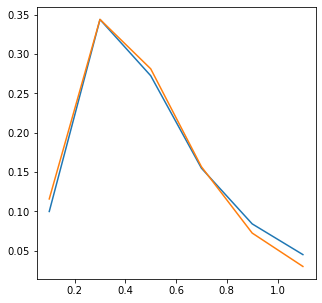

In [8]:
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.plot(df_pga_norm.num)

ax1.plot(df_pga_norm.fit)

# ax1.plot(x_range,p)

plt.show()

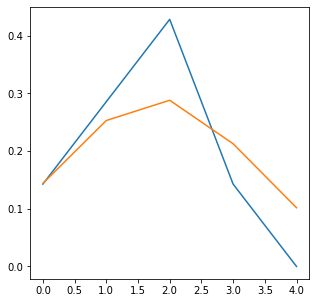

In [9]:
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.plot(df_ts_norm.num)

ax1.plot(df_ts_norm.fit)

# ax1.plot(x_range,p)

plt.show()

# Create network with nodes, arcs and outcomes added

In [10]:
net = create_BN(shape,scale,mu,sigma)

# Define Conditional prob tables

In [11]:
# CPT for combining fragilities
combining_cpt = create_combining_CPT()

# CPT for combining the three shaking functions depending on liquefaction
pga_cpt = create_PGA_CTP()

# Shaking
shaking_mu_list = [0.0588,0.0952,0.30808,0.413616]
shaking_sigma_list = [0.54,.58,.49,.57]
shaking_ds_list = ['DS1','DS2','DS3','DS4']
shaking_IM = np.arange(0.0001,10,0.1)
shaking_factors = [.98,.9,.8,.6]
shaking_bins = {
    'low':0.3001,
    'medium':0.6001,
    'high':0.9001
}

shaking_a_cpt = create_bins(shaking_factors[0],shaking_mu_list,shaking_sigma_list,shaking_ds_list,shaking_IM,shaking_bins)
shaking_b_cpt = create_bins(shaking_factors[1],shaking_mu_list,shaking_sigma_list,shaking_ds_list,shaking_IM,shaking_bins)
shaking_c_cpt = create_bins(shaking_factors[2],shaking_mu_list,shaking_sigma_list,shaking_ds_list,shaking_IM,shaking_bins)
shaking_d_cpt = create_bins(shaking_factors[3],shaking_mu_list,shaking_sigma_list,shaking_ds_list,shaking_IM,shaking_bins)

# Tsunami
tsunami_mu_list = [0.5,1,2,3.5]
tsunami_sigma_list = [.54,.58,.49,.57]
tsunami_ds_list = ['DS1','DS2','DS3','DS4']
tsunami_factors = [1]
tsunami_IM = np.arange(0.0001,3,0.1)
tsunami_bins = {
    'zero':0.0001,
    'low':0.2001,
    'medium':1.5001,
    'high':2.7001
}

tsunami_cpt = create_bins(tsunami_factors[0],tsunami_mu_list,tsunami_sigma_list,tsunami_ds_list,tsunami_IM,tsunami_bins)

# Liquefaction to liquefaction fragility
liquefaction_cpt = [1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1]

# Landslide fragility cpt
df_ds_landslide = pd.DataFrame.from_dict({0:{'DS0':1.0,'DS4':0.0},1:{'DS0':0.0,'DS4':1.0}},orient='index')
P_dict = {x:min(list(df_ds_landslide.index), key=lambda y:abs(y-x)) for x in [0,1]} 
landslide_cpt = sum([list(df_ds_landslide[df_ds_landslide.index==P_dict[x]].T[P_dict[x]]) for x in [0,1]],[])

In [12]:
# shaking to landslide cpt
# landslide_occurs_probs = [0,0.02235,0.0277,0.0424,0.0559,0.0849]
# landslide_doesnt_occur_probs = [1-x for x in landslide_occurs_probs]
shaking_to_landslide_cpt = [1,0,1-0.02235,0.02235,1-0.0277,0.0277,1-0.0424,0.0424,1-0.0559,0.0559,1-0.0849,0.0849]
net.set_node_definition('Landslide',shaking_to_landslide_cpt)

# Set CTPs 

In [13]:
net.set_node_definition('CombinedFragility',combining_cpt)
net.set_node_definition('ShakingAndLSNFragility',pga_cpt)
net.set_node_definition('ShakingAndLSNFragilityA',shaking_a_cpt)
net.set_node_definition('ShakingAndLSNFragilityB',shaking_b_cpt)
net.set_node_definition('ShakingAndLSNFragilityC',shaking_c_cpt)
net.set_node_definition('ShakingAndLSNFragilityD',shaking_d_cpt)
net.set_node_definition('TsunamiFragility',tsunami_cpt)
net.set_node_definition('LiquefactionModulator',liquefaction_cpt)
net.set_node_definition('LandslideFragility',landslide_cpt)

# plus the connection between shaking and liquefaction which is made up right now...
net.set_node_definition('Liquefaction',[0.8,0.2,0,0.4,0.5,0.1,0.1,0.3,0.6,0.1,0.3,0.6]) # needs updating

# Format & Save the network for GeNIe

In [14]:
net.set_node_position('ShakingContinuous',400,0,50,50)
net.set_node_position('ShakingContinuousForLS',1200,0,50,50)
net.set_node_position('ShakingForFrag',400,100,50,50)
net.set_node_position('Liquefaction',800,150,50,50)
net.set_node_position('Tsunami',1000,275,50,50)
net.set_node_position('TsunamiContinuous',1000,150,50,50)
net.set_node_position('Landslide',1200,275,50,50)
net.set_node_position('ShakingForLS',1200,150,50,50)
net.set_node_position('RunoutModelModifier',1400,275,50,50)
net.set_node_position('RunoutModels',1400,0,50,50)

net.set_node_position('ShakingContinuousForFrag',100,100,50,50)
net.set_node_position('ShakingAndLSNFragilityA',100,275,50,50)
net.set_node_position('ShakingAndLSNFragilityB',300,275,50,50)
net.set_node_position('ShakingAndLSNFragilityC',500,275,50,50)
net.set_node_position('ShakingAndLSNFragilityD',700,275,50,50)

net.set_node_position('ShakingAndLSNFragility',400,400,50,50)
net.set_node_position('LiquefactionModulator',800,400,50,50)
net.set_node_position('TsunamiFragility',1000,400,50,50)
net.set_node_position('LandslideFragility',1200,400,50,50)

net.set_node_position('CombinedFragility',900,525,50,50)

for node in net.get_all_nodes():
    net.set_node_chart_enabled(node,1)
    
net.write_file("compounding_hazards.xdsl")


In [ ]:
asdf

# Setting Evidence for each grid

In [ ]:
def get_evidence_list(mu,sigma,IM,bins):
    df_evidence_dist = pd.DataFrame.from_dict({im:lognorm(s=sigma,scale=math.exp(mu)).cdf(im) for im in IM},orient='index')
    evidence_dict = {key:df_evidence_dist.loc[min(list(df_evidence_dist.index), key=lambda y:abs(y-x))][0] for key,x in bins.items()} 
    # Normalise
    total_evidence = np.sum(list(evidence_dict.values()))
    evidence_list = [item/total_evidence for key,item in evidence_dict.items()]
    
    return(evidence_list)

In [ ]:
for i in range(50):
    evidence_dict = {
    'pga_mean':1,
    'pga_std':1,
    'tsunami_mean':1,
    'tsunami_std':1,
    'landslide':[1,0],
    }

    # Clear all existing evidence
    net.clear_all_evidence()

    # Get evidence
    shaking_evidence_list = get_evidence_list(evidence_dict['pga_std'],evidence_dict['pga_mean'],shaking_IM,shaking_bins)
    tsunami_evidence_list = get_evidence_list(evidence_dict['tsunami_std'],evidence_dict['tsunami_mean'],tsunami_IM,tsunami_bins)
    landslide_evidence_list = evidence_dict['landslide']

    # Apply evidence to network
    net.set_virtual_evidence('Shaking',shaking_evidence_list)
    net.set_virtual_evidence('Tsunami',tsunami_evidence_list)
    net.set_virtual_evidence('Landslide',landslide_evidence_list)

    # With the new evidence, update your belief
    net.update_beliefs()

    # Get the final probability
    prob = net.get_node_value('CombinedFragility')


prob

In [ ]:
evidence_list

In [ ]:
df_evidence_dist.loc[min(list(df_evidence_dist.index), key=lambda y:abs(y-x))]

In [ ]:
min(list(df_shaking_evidence_dist.index), key=lambda y:abs(y-x))